# `kissim`-based kinome tree

We generate `kissim`-based kinome trees based on three different kinase matrices:

- Kinase matrix based on all structures/fingerprints (**DFG-in and DFG-out**)
- Kinase matrix based on structure/fingerprints in **DFG-in** conformation only
- Kinase matrix based on structure/fingerprints in **DFG-out** conformation only

Check which kinases are covered by the DFG-in *and* the DFG-out `kissim` trees. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
from matplotlib_venn import venn2
from opencadd.databases.klifs import setup_remote

from kissim.comparison import FingerprintDistanceGenerator
from kissim.comparison import matrix, tree

In [3]:
# Set path to this notebook
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results"

In [4]:
# Set up KLIFS session
KLIFS_SESSION = setup_remote()

In [5]:
# Set bit coverage between fingerprint pairs
COVERAGE_MIN = 0.8

## Load fingerprint distances (all conformations)

In [6]:
%%time

fingerprint_distances = FingerprintDistanceGenerator.from_csv(
    RESULTS / "fingerprint_distances.csv"
)

CPU times: user 6.64 s, sys: 738 ms, total: 7.38 s
Wall time: 7.99 s


## Fetch DFG conformation

In [7]:
def dfg(structure_klifs_id1, structure_klifs_id2, structure_klifs_id_to_dfg_dict):
    """
    Return DFG conformation for structure pair if they have the same conformation.

    Parameters
    ----------
    structure_klifs_id1 : int
        Structure KLIFS ID.
    structure_klifs_id2 : int
        Structure KLIFS ID.
    structure_klifs_id_to_dfg_dict : dict
        DFG conformations (values) for structure KLIFS IDs (keys).

    Returns
    -------
    str or None
        DFG conformation if input structure pair has the same conformation, else None.
    """
    dfg1 = structure_klifs_id_to_dfg_dict[structure_klifs_id1]
    dfg2 = structure_klifs_id_to_dfg_dict[structure_klifs_id2]
    if dfg1 == dfg2:
        return dfg1
    else:
        return None

In [8]:
%%time

# List structure KLIFS IDs
structure_klifs_ids = pd.concat(
    [fingerprint_distances.data["structure.1"], fingerprint_distances.data["structure.2"]]
)
structure_klifs_ids = structure_klifs_ids.unique().tolist()
print(f"Number of structures: {len(structure_klifs_ids)}")

# Create a ID-to-DFG dictionary
structures = KLIFS_SESSION.structures.by_structure_klifs_id(structure_klifs_ids)
structure_klifs_id_to_dfg_dict = (
    structures[["structure.klifs_id", "structure.dfg"]]
    .set_index("structure.klifs_id")
    .to_dict()["structure.dfg"]
)

# Add DFG conformation of structure pairs (if structure pair has same conformation)
dfg_conformations = fingerprint_distances.data.apply(
    lambda x: dfg(x["structure.1"], x["structure.2"], structure_klifs_id_to_dfg_dict), axis=1
)
fingerprint_distances.data["dfg"] = dfg_conformations
fingerprint_distances.data.head()

Number of structures: 5222
CPU times: user 1min 47s, sys: 1.47 s, total: 1min 49s
Wall time: 1min 50s


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,dfg
0,3833,6679,AAK1,AAK1,0.051595,0.992667,in
1,3833,7156,AAK1,AAK1,0.057489,0.991333,in
2,3833,1086,AAK1,ABL1,0.271736,0.990667,None
3,3833,1054,AAK1,ABL1,0.290077,0.990667,None
4,3833,1090,AAK1,ABL1,0.266234,0.990667,in


## Generate trees

In [9]:
def generate_dfg_trees(structure_distances, dfg, coverage_min):
    """
    Generate kinome trees based on structure pairs filtered by DFG conformation and bit coverage.

    Parameters
    ----------
    structure_distances : pandas.DataFrame
        Distances and bit coverages per structure pair.
    dfg : str
        DFG conformation "in" or "out".
    coverage_min : float
        Minimal bit coverage a structure pair must have to be included.
    """

    if dfg in ["in", "out"]:
        structure_distances = structure_distances[structure_distances["dfg"] == dfg]

    print(f"Number of structures: {len(structure_distances)}")
    kinase_distance_matrix = matrix.kinase_distance_matrix(
        structure_distances,
        by="minimum",
        fill_diagonal=True,
        coverage_min=coverage_min,
    )
    print(f"Kinase matrix dimensions: {kinase_distance_matrix.shape}")

    tree.from_distance_matrix(
        kinase_distance_matrix,
        RESULTS / f"tree_dfg_{dfg}.tree",
        RESULTS / f"tree_annotation_dfg_{dfg}.csv",
    )

    return kinase_distance_matrix.columns.to_list()

### All conformations

In [10]:
kinases_all = generate_dfg_trees(fingerprint_distances.data, "all", COVERAGE_MIN)
print(len(kinases_all))

Number of structures: 13632031
Kinase matrix dimensions: (288, 288)
288


### DFG-in conformations

In [11]:
kinases_in = generate_dfg_trees(fingerprint_distances.data, "in", COVERAGE_MIN)
print(len(kinases_in))

Number of structures: 10140756
Kinase matrix dimensions: (266, 266)
266


### DFG-out conformations

In [12]:
kinases_out = generate_dfg_trees(fingerprint_distances.data, "out", COVERAGE_MIN)
print(len(kinases_out))

Number of structures: 105111
Kinase matrix dimensions: (70, 70)
70


## Intersection of kinases covered by both the DFG-in and DFG-out tree

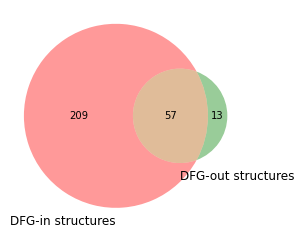

In [13]:
venn2([set(kinases_in), set(kinases_out)], set_labels=("DFG-in structures", "DFG-out structures"))

In [14]:
# Intersecting kinases
set(kinases_in) & set(kinases_out)

{'ABL1',
 'ABL2',
 'ACK',
 'AKT1',
 'AKT2',
 'ALK',
 'AMPKa2',
 'AurA',
 'BRAF',
 'CDK2',
 'CDK6',
 'CDK8',
 'CK1e',
 'EGFR',
 'EphA2',
 'EphA3',
 'EphA7',
 'EphB4',
 'FAK',
 'FGFR1',
 'FGFR4',
 'FMS',
 'HGK',
 'IGF1R',
 'INSR',
 'IRAK4',
 'JAK2',
 'JNK2',
 'KDR',
 'KIT',
 'LCK',
 'LOK',
 'MAP2K1',
 'MAP2K7',
 'MELK',
 'MER',
 'MET',
 'MNK2',
 'NEK2',
 'NEK7',
 'PAK1',
 'PDGFRa',
 'PDK1',
 'PEK',
 'PRP4',
 'PYK2',
 'RIPK2',
 'STLK5',
 'SYK',
 'TAK1',
 'TIE2',
 'TRKA',
 'TRKB',
 'ULK3',
 'p38a',
 'p38b',
 'p38d'}